In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import torch
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier

from data_cleaning import clean_data
from submission_utils import prediction_to_csv

In [2]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

train_data = clean_data(train_data)
test_data = clean_data(test_data)

n_train = int(len(train_data) * 0.8)
n_validate = len(train_data) - n_train
x_train = train_data.drop("Survived", axis=1).head(n_train)
y_train = train_data["Survived"].head(n_train)
x_validate = train_data.drop("Survived", axis=1).tail(n_validate)
y_validate = train_data["Survived"].tail(n_validate)

In [3]:
# Baseline: Random using prior
survival_prior = y_train.mean()
print("Prior prob. of survival: {:.2f}".format(survival_prior))
predictions = np.random.choice([0,1], len(y_validate), p=[1-survival_prior, survival_prior])
print("Validation accuracy: {:.2f}".format(accuracy_score(y_validate, predictions)))

Prior prob. of survival: 0.39
Validation accuracy: 0.53


Validation accuracy: 0.82


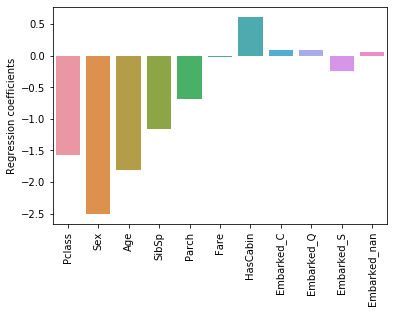

In [4]:
# Logistic regression
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_train)
validation_scaled = scaler.transform(x_validate)

logistic_regression = LogisticRegression(solver="lbfgs")
logistic_regression.fit(x_scaled, y_train)

predictions = logistic_regression.predict(validation_scaled)
print("Validation accuracy: {:.2f}".format(accuracy_score(y_validate, predictions)))
coeff_bars = sns.barplot(x_train.columns, logistic_regression.coef_[0])
coeff_bars.set_ylabel("Regression coefficients")
for item in coeff_bars.get_xticklabels():
    item.set_rotation("vertical")

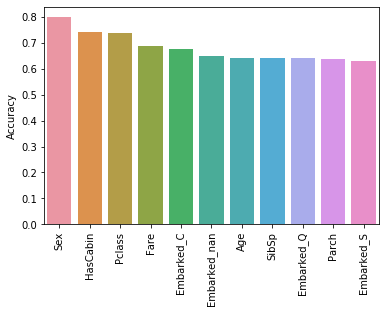

In [5]:
# Single-feature regressions
accuracies = {}
for independent_variable in x_train.columns:
    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x_train[[independent_variable]])
    logistic_regression = LogisticRegression(solver="lbfgs")
    logistic_regression.fit(x_scaled, y_train)
    x_scaled_validate = scaler.transform(x_validate[[independent_variable]])
    predictions = logistic_regression.predict(x_scaled_validate)
    acc = accuracy_score(y_validate, predictions)
    accuracies[independent_variable] = acc
accuracies_ordered = collections.OrderedDict({k: v for k, v in sorted(accuracies.items(), key=lambda item: item[1], reverse=True)})
acc_bars = sns.barplot(list(accuracies_ordered.keys()), list(accuracies_ordered.values()))
acc_bars.set_ylabel("Accuracy")
for item in acc_bars.get_xticklabels():
    item.set_rotation("vertical")

In [6]:
# Bayesian inference on sex
posteriors = {}
for sex in range(2):
    # likelihood: Probability of sex given survived
    joint_probability = len(train_data[(train_data["Survived"] == 1) & (train_data["Sex"] == sex)]) / len(train_data)
    likelihood = joint_probability / survival_prior

    # evidence: Number of sex / number of passengers
    evidence = len(train_data[train_data["Sex"] == sex]) / len(train_data)
    posterior = (likelihood * survival_prior) / evidence
    posteriors[sex] = posterior
def draw_survived(x):
    return np.random.choice([0,1], p=[1-posteriors[x], posteriors[x]])
predictions = x_validate["Sex"].apply(draw_survived)
print("Validation accuracy: {:.2f}".format(accuracy_score(y_validate, predictions)))

Validation accuracy: 0.66


In [7]:
# Gaussian Naive Bayes classifier using sex, age and fare
features = ["Sex", "Age",  "Fare"]
gnb = GaussianNB()
predictions = gnb.fit(x_train[features], y_train).predict(x_validate[features])
print("Validation accuracy GaussianNB (Sex, Age, Fare): {:.2f}".format(accuracy_score(y_validate, predictions)))

for feature in features:
    gnb = GaussianNB()
    x_train_feat = x_train[feature].to_numpy()
    x_train_feat = np.expand_dims(x_train_feat, -1)
    x_validate_feat = x_validate[feature].to_numpy()
    x_validate_feat = np.expand_dims(x_validate_feat, -1)
    predictions = gnb.fit(x_train_feat, y_train).predict(x_validate_feat)
    print("Validation accuracy GaussianNB ({}): {:.2f}".format(feature, accuracy_score(y_validate, predictions)))

    
bnb = BernoulliNB()
x_train_feat = x_train["Sex"].to_numpy()
x_train_feat = np.expand_dims(x_train_feat, -1)
x_validate_feat = x_validate["Sex"].to_numpy()
x_validate_feat = np.expand_dims(x_validate_feat, -1)
predictions = bnb.fit(x_train_feat, y_train).predict(x_validate_feat)
print("Validation accuracy BernoulliNB (Sex): {:.2f}".format(accuracy_score(y_validate, predictions)))


Validation accuracy GaussianNB (Sex, Age, Fare): 0.81
Validation accuracy GaussianNB (Sex): 0.80
Validation accuracy GaussianNB (Age): 0.64
Validation accuracy GaussianNB (Fare): 0.72
Validation accuracy BernoulliNB (Sex): 0.80


In [8]:
# Random Forest
forests = []
for n_estimators in range(10, 100, 10):
    for criterion in ["gini", "entropy"]:
        random_forest = RandomForestClassifier(n_estimators=100)
        random_forest.fit(x_train, y_train)
        acc = random_forest.score(x_validate, y_validate)
        forests.append({
            "n_estimators": n_estimators,
            "criterion": criterion,
            "acc": acc,
            "model": random_forest
        })
best_acc = 0
best_forest = None
for forest in forests:
    if forest["acc"] > best_acc:
        best_acc = forest["acc"]
        best_forest = forest
print("Validate accuracy random forest: {:.2f}".format(best_forest["acc"]))
for parameter in filter(lambda item: item[0] not in ["acc", "model"], best_forest.items()):
    print("{}: {}".format(*parameter))

test_predictions = best_forest["model"].predict(test_data)
prediction_to_csv(test_predictions, "random_forest.csv")
# Test accuracy 0.75598

Validate accuracy random forest: 0.85
n_estimators: 50
criterion: entropy


In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def acc(output, label):
    pred = output >= 0.5
    target = label >= 0.5
    return pred.eq(target).sum() / float(target.numel())

def train(model: torch.nn.Module, inputs_train: torch.Tensor, labels_train: torch.Tensor, 
          inputs_validate: torch.Tensor, labels_validate: torch.Tensor, n_epochs: int, batch_size: int, lr: float):
    model = model.to(device)
    train_data = torch.utils.data.TensorDataset(inputs_train, labels_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True, num_workers=1, pin_memory=True)
    validate_data = torch.utils.data.TensorDataset(inputs_validate, labels_validate)
    validate_loader = torch.utils.data.DataLoader(validate_data, batch_size, shuffle=True, num_workers=1, pin_memory=True)
    optimizer = torch.optim.Adam(model.parameters(), lr)
    loss_fn = torch.nn.BCELoss()
    losses = []
    accs = []
    
    print_every = int(n_epochs / 10)
    
    for epoch in range(n_epochs):
        avg_train_loss = 0
        avg_train_acc = 0
        avg_validate_loss = 0
        avg_validate_acc = 0
        
        model = model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            avg_train_loss += loss.item()
            avg_train_acc += acc(outputs, labels).item()
        
        avg_train_loss /= len(train_loader)
        avg_train_acc /= len(train_loader)
        if epoch % print_every == 0 or epoch == n_epochs - 1:
            print("[{} / {}] Train loss: {:.5f}, acc: {:.5f}".format(epoch, n_epochs,
                                                                     avg_train_loss, avg_train_acc))
        losses.append(avg_train_loss)
        accs.append(avg_train_acc)
        
        model = model.eval()
        with torch.no_grad():
            for inputs, labels in validate_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                
                avg_validate_loss += loss.item()
                avg_validate_acc += acc(outputs, labels).item()

            avg_validate_loss /= len(validate_loader)
            avg_validate_acc /= len(validate_loader)
            if epoch % print_every == 0 or epoch == n_epochs - 1:
                print("[{} / {}] Validate loss: {:.5f}, acc: {:.5f}".format(epoch, n_epochs, 
                                                                         avg_validate_loss, avg_validate_acc))
            losses.append(avg_validate_loss)
            accs.append(avg_validate_acc)

    return losses, accs

In [10]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train.to_numpy())
x_validate_scaled = scaler.fit_transform(x_validate.to_numpy())
input_train = torch.from_numpy(x_train_scaled).float()
label_train = torch.from_numpy(y_train.to_numpy()).float().unsqueeze(-1)
input_validate = torch.from_numpy(x_validate_scaled).float()
label_validate = torch.from_numpy(y_validate.to_numpy()).float().unsqueeze(-1)

In [11]:
# Neural net
class DenseNet(torch.nn.Module):
    def __init__(self, n_inputs, n_layers: int, width: int):
        super(DenseNet, self).__init__()
        self.input_layer = torch.nn.Linear(n_inputs, width)
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(width, width) for _ in range(n_layers)])
        self.output_layer = torch.nn.Linear(width, 1)
    
    def forward(self, x):
        x = torch.nn.SELU()(self.input_layer(x))
        for linear_layer in self.linear_layers:
            x = torch.nn.SELU()(linear_layer(x))
        x = torch.nn.Sigmoid()(self.output_layer(x))
        return x

[0 / 500] Train loss: 0.66480, acc: 0.61005
[0 / 500] Validate loss: 0.64800, acc: 0.63816
[50 / 500] Train loss: 0.50979, acc: 0.77853
[50 / 500] Validate loss: 0.46778, acc: 0.80702
[100 / 500] Train loss: 0.48093, acc: 0.78940
[100 / 500] Validate loss: 0.42190, acc: 0.82977
[150 / 500] Train loss: 0.45826, acc: 0.79755
[150 / 500] Validate loss: 0.40898, acc: 0.82621
[200 / 500] Train loss: 0.46660, acc: 0.79348
[200 / 500] Validate loss: 0.42064, acc: 0.83470
[250 / 500] Train loss: 0.45093, acc: 0.80435
[250 / 500] Validate loss: 0.41447, acc: 0.83827
[300 / 500] Train loss: 0.44602, acc: 0.80571
[300 / 500] Validate loss: 0.40117, acc: 0.84348
[350 / 500] Train loss: 0.43714, acc: 0.81386
[350 / 500] Validate loss: 0.40550, acc: 0.84512
[400 / 500] Train loss: 0.44363, acc: 0.81114
[400 / 500] Validate loss: 0.39075, acc: 0.84868
[450 / 500] Train loss: 0.43401, acc: 0.81522
[450 / 500] Validate loss: 0.38341, acc: 0.85581
[499 / 500] Train loss: 0.45059, acc: 0.80842
[499 / 500

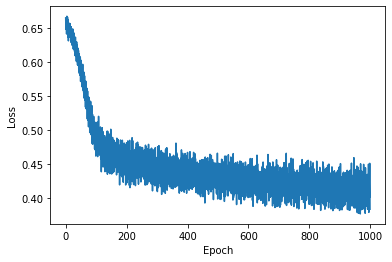

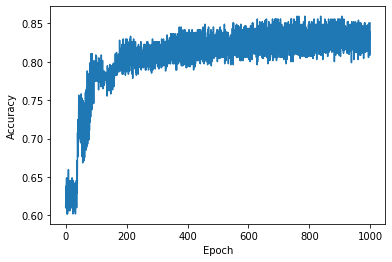

In [13]:
num_epochs = 500
batch_size = 32
num_layers = 3
width = 8
learning_rate = 1e-4
model = DenseNet(input_train.size(-1), num_layers, width)
losses, accs = train(model, input_train, label_train, input_validate, label_validate,
                     num_epochs, batch_size, learning_rate)
plt.plot(range(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.plot(range(len(accs)), accs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()